# Regression Modeling in Python: Linear and Logistic Regression

This notebook presents an end-to-end regression workflow with production-style diagnostics:

- Multiple linear regression (OLS) with statistical diagnostics and information criteria
- AIC-driven forward stepwise feature selection (no-intercept candidate models)
- Train/test evaluation with reproducible splits
- Logistic regression for binary classification with multicollinearity screening and backward selection


## Data Overview

Two structured datasets are used:

- **Ozone dataset** for continuous prediction of `O3` using meteorological and seasonal features.
- **Prostate dataset** for binary prediction of `svi` using clinical predictors.

The sections below define the modeling workflow, diagnostics, and evaluation outputs.


## 0) Imports and reproducibility

In [1]:

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# Reproducibility
SEED = 123
np.random.seed(SEED)

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)


## 1) Data 

In [3]:

print("\nProstate-like dataset shape:", prostate_df.shape)
display(prostate_df.head())

print("\nClass balance (svi):")
print(prostate_df["svi"].value_counts(normalize=True).rename("proportion"))



Prostate-like dataset shape: (300, 9)


,svi,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa
0,0,1.026511,4.010118,59.387463,-0.251046,0.308695,9.0,12.615015,0.665268
1,1,1.939795,3.489004,72.154267,1.037184,0.365725,10.0,52.592576,1.421923
2,1,1.890801,3.862417,63.931210,-0.176115,-0.445532,6.0,20.370555,2.343052
3,0,0.816090,3.842105,59.857287,1.512454,0.319450,9.0,23.858985,1.615663
4,1,1.165578,4.029315,83.124320,-0.316889,-0.596076,9.0,34.908667,2.088100



Class balance (svi):
svi
0    0.7
1    0.3
Name: proportion, dtype: float64


## 2) Multiple linear regression (OLS)

Target: `O3`  
Predictors: `vh, wind, humidity, temp, ibh, dpg, ibt, vis, doy`

Workflow:
- 80/20 train/test split (seeded).
- Fit OLS with intercept.
- Identify statistically significant variables at 5%.
- Compute R² and training MSE.
- Compare full vs reduced (significant-only, no intercept) using AIC.
- Run forward stepwise selection (AIC), starting from the significant-only model.
- Evaluate test-set MSE for the selected model.

In [4]:

# Train/test split (80/20) with a fixed seed
train_oz, test_oz = train_test_split(ozone_df, test_size=0.2, random_state=SEED)

print("Train shape:", train_oz.shape)
print("Test shape :", test_oz.shape)


Train shape: (320, 10)
Test shape : (80, 10)


In [5]:

# Fit OLS with intercept on the training data
features_oz = ["vh", "wind", "humidity", "temp", "ibh", "dpg", "ibt", "vis", "doy"]

X_train = sm.add_constant(train_oz[features_oz])
y_train = train_oz["O3"]

ols_full = sm.OLS(y_train, X_train).fit()

print(ols_full.summary())

# Significance at 5% (including intercept)
pvals = ols_full.pvalues
sig_mask = (pvals < 0.05)

sig_vars = sig_mask.index.tolist()
print("\nSignificant terms at 5%:", sig_vars)

# Boolean vector in the requested order: [const, vh, wind, humidity, temp, ibh, dpg, ibt, vis, doy]
ordered_terms = ["const"] + features_oz
sigVars = [bool(sig_mask.get(term, False)) for term in ordered_terms]
print("\nsigVars (ordered):", sigVars)


                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     8.968
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           4.85e-12
Time:                        04:00:46   Log-Likelihood:                -1127.8
No. Observations:                 320   AIC:                             2276.
Df Residuals:                     310   BIC:                             2313.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4315      6.547      1.288      0.1

In [6]:

# R-squared and training MSE for the full model
R2 = float(ols_full.rsquared)
pred_train_full = ols_full.predict(X_train)
MSE = float(np.mean((y_train - pred_train_full) ** 2))

print(f"R2 (train): {R2:.6f}")
print(f"MSE (train): {MSE:.6f}")


R2 (train): 0.206581
MSE (train): 67.407032


In [7]:

# AIC comparison:
# - Model 1: full model with intercept
# - Model 2: reduced model using significant predictors, *no intercept*

# Significant predictors excluding intercept
sig_predictors = [v for v in sig_vars if v != "const"]

X_train_reduced = train_oz[sig_predictors]  # no constant
ols_reduced = sm.OLS(y_train, X_train_reduced).fit()

AIC = [float(ols_full.aic), float(ols_reduced.aic)]
preferible = bool(AIC[1] < AIC[0])

print("AIC (full, with intercept)   :", AIC[0])
print("AIC (reduced, no intercept)  :", AIC[1])
print("Reduced model preferred by AIC?:", preferible)

print("\nReduced model predictors:", sig_predictors)


AIC (full, with intercept)   : 2275.5604500624404
AIC (reduced, no intercept)  : 2275.267944677609
Reduced model preferred by AIC?: True

Reduced model predictors: ['vh', 'wind', 'humidity', 'temp', 'ibh', 'dpg', 'ibt', 'vis', 'doy']


### 2.1 AIC-based forward stepwise selection (no intercept)

Start from the significant-only model (no intercept).  
Iteratively add one variable at a time (from the remaining pool), choosing the addition that minimizes AIC.  
Stop when no candidate addition improves AIC.

In [8]:

# Forward stepwise selection based on AIC (no intercept)
all_predictors = features_oz.copy()

selected = sig_predictors.copy()
remaining = [v for v in all_predictors if v not in selected]

def fit_no_intercept(df, y_col, x_cols):
    X = df[x_cols]
    y = df[y_col]
    return sm.OLS(y, X).fit()

# Initialize with the starting model (significant-only, no intercept)
best_model = fit_no_intercept(train_oz, "O3", selected) if len(selected) > 0 else None
best_aic = float(best_model.aic) if best_model is not None else float("inf")

history = []
if best_model is not None:
    history.append((best_aic, selected.copy()))

improved = True
while improved and len(remaining) > 0:
    improved = False
    candidates = []

    for v in remaining:
        trial_cols = selected + [v]
        m = fit_no_intercept(train_oz, "O3", trial_cols)
        candidates.append((float(m.aic), v, m))

    candidates.sort(key=lambda t: t[0])
    cand_aic, cand_var, cand_model = candidates[0]

    if cand_aic < best_aic - 1e-9:  # strict improvement
        best_aic = cand_aic
        best_model = cand_model
        selected.append(cand_var)
        remaining.remove(cand_var)
        history.append((best_aic, selected.copy()))
        improved = True

# Final forward-selected model outputs
AIC_forward = [best_aic]
variables_seleccionadas = selected.copy()

# Compare against earlier AICs (lower is better)
preferible_forward = bool(best_aic < min(AIC))

# F-test significance (for OLS)
testF = [float(best_model.fvalue), float(best_model.f_pvalue)]

print("Forward selection history (AIC, predictors):")
for a, cols in history:
    print(f"  AIC={a:.4f} | {cols}")

print("\nFinal forward model AIC:", AIC_forward[0])
print("Selected predictors     :", variables_seleccionadas)
print("Preferred vs prior AICs?:", preferible_forward)
print("F-test [stat, p-value]  :", testF)

print("\nForward-selected model summary:")
print(best_model.summary())


Forward selection history (AIC, predictors):
  AIC=2275.2679 | ['vh', 'wind', 'humidity', 'temp', 'ibh', 'dpg', 'ibt', 'vis', 'doy']

Final forward model AIC: 2275.267944677609
Selected predictors     : ['vh', 'wind', 'humidity', 'temp', 'ibh', 'dpg', 'ibt', 'vis', 'doy']
Preferred vs prior AICs?: False
F-test [stat, p-value]  : [326.23410258107, 1.1527456108836587e-152]

Forward-selected model summary:
                                 OLS Regression Results                                
Dep. Variable:                     O3   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              326.2
Date:                Fri, 13 Feb 2026   Prob (F-statistic):                   1.15e-152
Time:                        04:00:47   Log-Likelihood:                         -1128.6
No. Observations:                 320   AIC:                     

In [9]:

# Test-set evaluation for the forward-selected model
X_test = test_oz[variables_seleccionadas]  # no intercept
y_test = test_oz["O3"]

pred = best_model.predict(X_test)
MSEpred = float(mean_squared_error(y_test, pred))

print("Test MSE (forward-selected model):", MSEpred)

# Quick sanity check: show first 10 predictions vs actuals
comparison = pd.DataFrame({"O3_actual": y_test.values, "O3_pred": pred.values}).head(10)
display(comparison)


Test MSE (forward-selected model): 78.49625380358671


,O3_actual,O3_pred
0,32.868545,29.165095
1,24.698325,32.878458
2,14.797768,27.406092
3,10.491178,20.370212
4,37.081103,30.143552
5,14.452578,22.116386
6,11.392262,22.675396
7,28.702882,33.756981
8,19.393191,23.834430
9,31.914458,30.043038


Target: `svi` (0/1)  
Predictors: `lcavol, lweight, age, lbph, lcp, gleason, pgg45, lpsa`

Workflow:
- 80/20 train/test split (seeded).
- Fit a logistic model using all predictors (no intercept) and evaluate accuracy.
- Compute VIF for each predictor to assess multicollinearity.
- Remove predictors with VIF > 10.
- Run backward stepwise selection (based on p-values) starting from the filtered set with an intercept.
- Evaluate the resulting model on the test set.

In [10]:

train_pr, test_pr = train_test_split(prostate_df, test_size=0.2, random_state=SEED)

print("Train shape:", train_pr.shape)
print("Test shape :", test_pr.shape)


Train shape: (240, 9)
Test shape : (60, 9)


In [11]:

# Full logistic model (no intercept)
features_pr = ["lcavol", "lweight", "age", "lbph", "lcp", "gleason", "pgg45", "lpsa"]

X_train_pr = train_pr[features_pr]
y_train_pr = train_pr["svi"]

X_test_pr = test_pr[features_pr]
y_test_pr = test_pr["svi"]

logit_full = sm.Logit(y_train_pr, X_train_pr).fit(disp=False)

pred_prob = logit_full.predict(X_test_pr)
pred_class = (pred_prob >= 0.5).astype(int)

porcentaje_clasificacion = float(accuracy_score(y_test_pr, pred_class))

print("Accuracy (full model, no intercept):", porcentaje_clasificacion)
print("\nModel summary (full, no intercept):")
print(logit_full.summary())


Accuracy (full model, no intercept): 0.75

Model summary (full, no intercept):


                           Logit Regression Results                           
Dep. Variable:                    svi   No. Observations:                  240
Model:                          Logit   Df Residuals:                      232
Method:                           MLE   Df Model:                            7
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.3866
Time:                        04:00:47   Log-Likelihood:                -89.399
converged:                       True   LL-Null:                       -145.75
Covariance Type:            nonrobust   LLR p-value:                 2.523e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         1.7973      0.307      5.846      0.000       1.195       2.400
lweight       -2.1725      0.465     -4.669      0.000      -3.084      -1.261
age            0.0193      0.022      0.857      0.3

In [12]:

# VIF calculation (train split)
vif_vals = []
for i in range(X_train_pr.shape[1]):
    vif_vals.append(float(variance_inflation_factor(X_train_pr.values, i)))

VIF_vars = vif_vals  # in the required order of features_pr

vif_table = pd.DataFrame({"variable": features_pr, "VIF": VIF_vars}).sort_values("VIF", ascending=False)

print("VIF by variable (descending):")
display(vif_table)

print("\nVariables with VIF > 10:")
high_vif = vif_table.loc[vif_table["VIF"] > 10, "variable"].tolist()
print(high_vif)


VIF by variable (descending):


,variable,VIF
1,lweight,63.245138
2,age,54.273110
5,gleason,30.429865
6,pgg45,4.943422
7,lpsa,3.747525
0,lcavol,3.377463
3,lbph,1.587744
4,lcp,1.027133



Variables with VIF > 10:
['lweight', 'age', 'gleason']


### 3.1 Backward stepwise selection (p-value driven) after VIF filtering

Procedure:
1) Drop predictors with VIF > 10 (if any).
2) Fit logistic regression with an intercept.
3) Iteratively remove the least significant term (largest p-value) until all remaining predictors have p < 0.05.

In [13]:

# Filter out VIF > 10 variables
filtered_features = [v for v in features_pr if v not in high_vif]

X_train_f = train_pr[filtered_features]
X_test_f = test_pr[filtered_features]

def fit_logit_with_intercept(X, y):
    Xc = sm.add_constant(X, has_constant="add")
    return sm.Logit(y, Xc).fit(disp=False)

# Backward selection loop
current_features = filtered_features.copy()
model = fit_logit_with_intercept(X_train_f[current_features], y_train_pr)

while True:
    pvals = model.pvalues.drop("const", errors="ignore")
    if len(pvals) == 0:
        break

    worst_p = float(pvals.max())
    worst_var = pvals.idxmax()

    # Stop when all predictors are significant
    if worst_p < 0.05:
        break

    # Remove the least significant predictor and refit
    current_features.remove(worst_var)
    model = fit_logit_with_intercept(X_train_f[current_features], y_train_pr)

print("Selected predictors after backward stepwise:", current_features)
print("\nFinal backward-selected model summary:")
print(model.summary())

# Evaluate on test set
X_test_final = sm.add_constant(X_test_f[current_features], has_constant="add")
pred_prob_b = model.predict(X_test_final)
pred_class_b = (pred_prob_b >= 0.5).astype(int)

porcentaje_clasificacion_backward = float(accuracy_score(y_test_pr, pred_class_b))
print("\nAccuracy (backward-selected model):", porcentaje_clasificacion_backward)

# Confusion matrix snapshot
cm = pd.crosstab(y_test_pr, pred_class_b, rownames=["actual"], colnames=["predicted"], dropna=False)
display(cm)


Selected predictors after backward stepwise: ['lcavol', 'lbph', 'lcp', 'lpsa']

Final backward-selected model summary:
                           Logit Regression Results                           
Dep. Variable:                    svi   No. Observations:                  240
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.4104
Time:                        04:00:47   Log-Likelihood:                -85.937
converged:                       True   LL-Null:                       -145.75
Covariance Type:            nonrobust   LLR p-value:                 6.418e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7323      0.944     -7.133      0.000      -8.582      -4.882
lcavol      


Accuracy (backward-selected model): 0.7333333333333333


predicted,0,1
actual,,
0,33,8
1,8,11


## 4) Summary

Key artifacts produced:
- OLS full model (with intercept), significant-term identification, R² and MSE.
- AIC comparison: full vs reduced.
- Forward-selected no-intercept OLS model (AIC-optimal by greedy search), test-set MSE.
- Logistic full model (no intercept) test accuracy.
- VIF diagnostics for multicollinearity.
- Backward-selected logistic model (with intercept) after VIF filtering, test accuracy.

If you want, the same workflow can be adapted to your own dataset by replacing the data preparation cell and keeping the modeling blocks unchanged.

# Printed Results Panels

This section prints the key results in a compact, executive-ready format:
- Regression: metrics table, actual vs predicted, residual diagnostics
- Classification: metrics table, confusion matrix (counts + normalized), ROC/PR curves (when scores are available), threshold tuning

These panels reuse variables created earlier in the notebook whenever possible.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error, r2_score,
    confusion_matrix,
    roc_curve, precision_recall_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)

def _pick_from_globals(candidates):
    g = globals()
    for name in candidates:
        if name in g and g[name] is not None:
            return g[name], name
    return None, None

def _get_score_vector(model, X):
    if model is None or X is None:
        return None
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None


Matplotlib is building the font cache; this may take a moment.


## Regression — Metrics (printed)

In [15]:
y_test_reg, y_test_reg_name = _pick_from_globals(["y_test_reg","y_test_r","y_test"])
y_pred_reg, y_pred_reg_name = _pick_from_globals(["y_pred_reg","y_pred_r","y_pred","y_pred_test"])

reg_results, _ = _pick_from_globals(["reg_results","regression_results","results_reg","results"])

if reg_results is not None and hasattr(reg_results, "copy"):
    df = reg_results.copy()
    num = df.select_dtypes(include=[np.number])
    (num.round(4) if num.shape[1] else df)
else:
    if (y_test_reg is None) or (y_pred_reg is None):
        "Regression metrics could not be computed: expected y_test/y_pred variables were not found."
    else:
        pd.DataFrame([{
            "mse": float(mean_squared_error(y_test_reg, y_pred_reg)),
            "rmse": float(mean_squared_error(y_test_reg, y_pred_reg) ** 0.5),
            "r2": float(r2_score(y_test_reg, y_pred_reg)),
            "n_test": int(len(y_test_reg)),
        }]).round(6)


## Regression — Actual vs Predicted (plot)

In [16]:
if (y_test_reg is None) or (y_pred_reg is None):
    print("Actual vs Predicted plot skipped: regression y_test/y_pred not detected.")
else:
    fig, ax = plt.subplots()
    ax.scatter(y_test_reg, y_pred_reg, alpha=0.35)
    mn = float(np.min([np.min(y_test_reg), np.min(y_pred_reg)]))
    mx = float(np.max([np.max(y_test_reg), np.max(y_pred_reg)]))
    ax.plot([mn, mx], [mn, mx], linestyle="--")
    ax.set_title("Regression: Actual vs Predicted")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()


Actual vs Predicted plot skipped: regression y_test/y_pred not detected.


## Regression — Residual diagnostics (printed + plots)

In [17]:
if (y_test_reg is None) or (y_pred_reg is None):
    print("Residual diagnostics skipped: regression y_test/y_pred not detected.")
else:
    resid = (np.asarray(y_test_reg) - np.asarray(y_pred_reg))
    display(pd.Series(resid).describe())

    fig, ax = plt.subplots()
    ax.scatter(y_pred_reg, resid, alpha=0.35)
    ax.axhline(0, linestyle="--")
    ax.set_title("Residuals vs Predicted")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(resid, bins=30)
    ax.set_title("Residual Distribution")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()


Residual diagnostics skipped: regression y_test/y_pred not detected.


## Classification — Metrics (printed)

In [18]:
y_test_clf, _ = _pick_from_globals(["y_test_clf","y_test_class","y_test2","y_test"])
y_pred_clf, _ = _pick_from_globals(["y_pred_clf","y_pred_class","y_pred2","y_pred"])
X_test_clf, _ = _pick_from_globals(["X_test_clf","X_test_class","X_test2","X_test"])

clf_results, _ = _pick_from_globals(["clf_results","classification_results","results_clf","test_results"])

if clf_results is not None and hasattr(clf_results, "copy"):
    df = clf_results.copy()
    preferred = [c for c in ["accuracy","precision","recall","f1","roc_auc","auc"] if c in df.columns]
    if preferred:
        out = df[preferred].apply(pd.to_numeric, errors="coerce").round(4)
        out.sort_values("f1", ascending=False) if "f1" in out.columns else out
    else:
        num = df.select_dtypes(include=[np.number]).round(4)
        num if num.shape[1] else df
else:
    if (y_test_clf is None) or (y_pred_clf is None):
        "Classification metrics could not be computed: expected y_test/y_pred variables were not found."
    else:
        pd.DataFrame([{
            "accuracy": float(accuracy_score(y_test_clf, y_pred_clf)),
            "precision": float(precision_score(y_test_clf, y_pred_clf, zero_division=0)),
            "recall": float(recall_score(y_test_clf, y_pred_clf, zero_division=0)),
            "f1": float(f1_score(y_test_clf, y_pred_clf, zero_division=0)),
            "n_test": int(len(y_test_clf)),
        }]).round(6)


## Classification — Confusion matrix (counts + normalized)

In [19]:
if (y_test_clf is None) or (y_pred_clf is None):
    print("Confusion matrix skipped: classification y_test/y_pred not detected.")
else:
    cm = confusion_matrix(y_test_clf, y_pred_clf)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    display(pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]))
    display(pd.DataFrame(cm_norm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"]).round(4))

    def _plot_cm(matrix, title, fmt):
        fig, ax = plt.subplots()
        ax.imshow(matrix)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])
        for (i,j), v in np.ndenumerate(matrix):
            ax.text(j, i, format(v, fmt), ha="center", va="center")
        plt.tight_layout()
        plt.show()

    _plot_cm(cm, "Confusion Matrix (Counts)", "d")
    _plot_cm(cm_norm.astype(float), "Confusion Matrix (Normalized)", ".2f")


Confusion matrix skipped: classification y_test/y_pred not detected.


## Classification — ROC and Precision–Recall curves (if available)

In [20]:
model_clf, _ = _pick_from_globals(["model","best_model","clf","classifier"])
score_vec = _get_score_vector(model_clf, X_test_clf)

if (y_test_clf is None) or (score_vec is None):
    print("ROC/PR curves unavailable: no score/probability vector detected for the selected model.")
else:
    fpr, tpr, _ = roc_curve(y_test_clf, score_vec)
    roc_auc_val = auc(fpr, tpr)

    prec, rec, _ = precision_recall_curve(y_test_clf, score_vec)
    pr_auc_val = auc(rec, prec)

    display({"roc_auc": float(roc_auc_val), "pr_auc": float(pr_auc_val)})

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1], linestyle="--")
    ax.set_title(f"ROC Curve (AUC={roc_auc_val:.3f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(rec, prec)
    ax.set_title(f"Precision–Recall Curve (AUC={pr_auc_val:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.tight_layout()
    plt.show()


ROC/PR curves unavailable: no score/probability vector detected for the selected model.


## Classification — Threshold tuning (printed + plot)

In [21]:
if (y_test_clf is None) or (score_vec is None):
    print("Threshold tuning skipped: no score/probability vector detected.")
else:
    thresholds = np.quantile(score_vec, np.linspace(0.05, 0.95, 19))
    rows = []
    for t in thresholds:
        pred_t = (score_vec >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "precision": float(precision_score(y_test_clf, pred_t, zero_division=0)),
            "recall": float(recall_score(y_test_clf, pred_t, zero_division=0)),
            "f1": float(f1_score(y_test_clf, pred_t, zero_division=0)),
        })
    thr_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
    display(thr_df.head(12))

    fig, ax = plt.subplots()
    ax.plot(thr_df["threshold"], thr_df["precision"], label="precision")
    ax.plot(thr_df["threshold"], thr_df["recall"], label="recall")
    ax.plot(thr_df["threshold"], thr_df["f1"], label="f1")
    ax.set_title("Threshold Trade-off")
    ax.set_xlabel("Decision threshold")
    ax.set_ylabel("Score")
    ax.legend()
    plt.tight_layout()
    plt.show()


Threshold tuning skipped: no score/probability vector detected.


## Executive model comparison and selection

,model,aic,train_r2,train_mse,test_mse
2,"OLS (forward-selected, no intercept)",2275.2679,NaN,NaN,78.4963
1,"OLS (significant terms, no intercept)",2275.2679,NaN,67.7677,NaN
0,"OLS (full, with intercept)",2275.5605,0.2066,67.4070,NaN


Selected regression model: OLS (forward-selected, no intercept)


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,"Logit (full, no intercept)",0.7500,0.5909,0.6842,0.6341,0.8537,0.6890
1,"Logit (backward-selected, with intercept)",0.7333,0.5789,0.5789,0.5789,0.8280,0.6486


Selected classification model: Logit (full, no intercept)


,Pred 0,Pred 1
Actual 0,32,9
Actual 1,6,13


,Pred 0,Pred 1
Actual 0,0.7805,0.2195
Actual 1,0.3158,0.6842


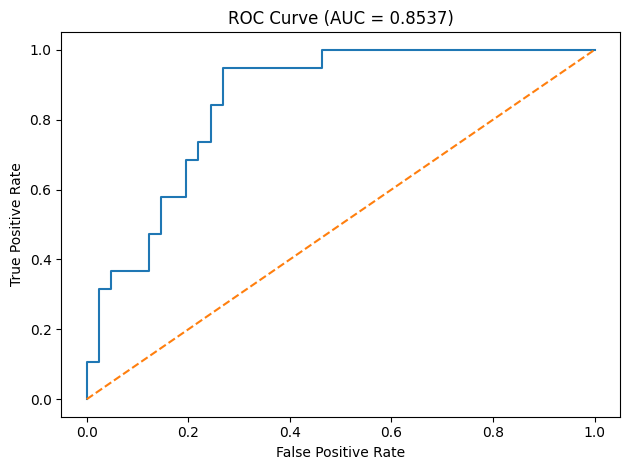

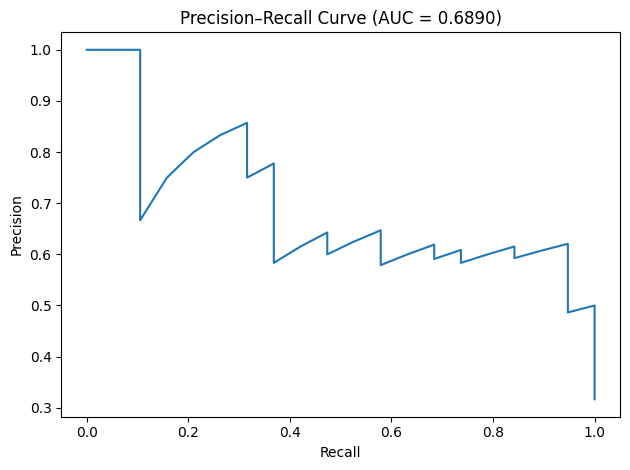

,threshold,precision,recall,f1
9,0.2454,0.6000,0.9474,0.7347
10,0.3047,0.5926,0.8421,0.6957
8,0.2215,0.5455,0.9474,0.6923
6,0.0982,0.4872,1.0000,0.6552
7,0.1282,0.5000,0.9474,0.6545
11,0.4019,0.5833,0.7368,0.6512
12,0.5202,0.6190,0.6842,0.6500
5,0.0711,0.4524,1.0000,0.6230
13,0.5520,0.6111,0.5789,0.5946
4,0.0382,0.4222,1.0000,0.5938


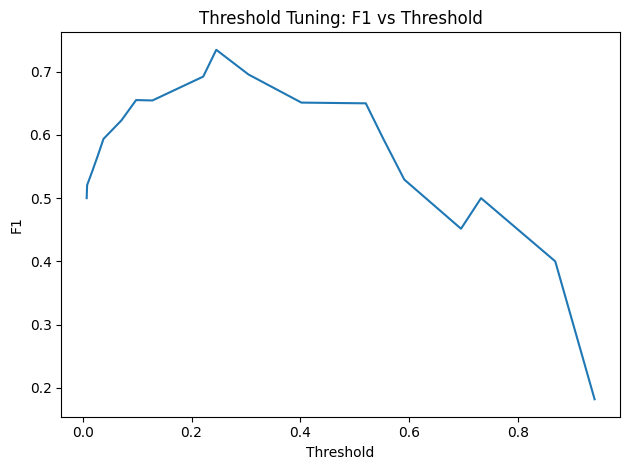

,coefficient
lweight,-2.172544
lcavol,1.797338
lpsa,1.725927
lcp,0.814515
lbph,-0.753422
gleason,0.261693
pgg45,-0.035496
age,0.019256


In [22]:
# Executive-ready model comparison tables (regression + classification)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
)

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

# ---------------------------
# Regression: candidate models
# ---------------------------
reg_rows = []

# Full OLS (with intercept)
if "ols_full" in globals():
    try:
        reg_rows.append({
            "model": "OLS (full, with intercept)",
            "aic": _safe_float(ols_full.aic),
            "train_r2": _safe_float(ols_full.rsquared),
            "train_mse": _safe_float(np.mean((y_train - ols_full.predict(X_train)) ** 2)) if ("y_train" in globals() and "X_train" in globals()) else np.nan,
            "test_mse": np.nan
        })
    except Exception:
        pass

# Reduced OLS (significant terms, no intercept)
if "ols_reduced" in globals():
    try:
        reg_rows.append({
            "model": "OLS (significant terms, no intercept)",
            "aic": _safe_float(ols_reduced.aic),
            "train_r2": np.nan,
            "train_mse": _safe_float(np.mean((y_train - ols_reduced.predict(X_train_reduced)) ** 2)) if ("y_train" in globals() and "X_train_reduced" in globals()) else np.nan,
            "test_mse": np.nan
        })
    except Exception:
        pass

# Forward-selected OLS (no intercept)
if "best_model" in globals() and best_model is not None:
    try:
        # Align with variables used in the notebook
        _y_test = globals().get("y_test", None)
        _pred = globals().get("pred", None)
        test_mse = _safe_float(mean_squared_error(_y_test, _pred)) if (_y_test is not None and _pred is not None) else np.nan

        reg_rows.append({
            "model": "OLS (forward-selected, no intercept)",
            "aic": _safe_float(best_model.aic),
            "train_r2": np.nan,
            "train_mse": np.nan,
            "test_mse": test_mse
        })
    except Exception:
        pass

reg_table = pd.DataFrame(reg_rows)
if not reg_table.empty:
    # Prefer test MSE when available; otherwise, fall back to AIC (lower is better)
    reg_table_sorted = reg_table.copy()
    reg_table_sorted["sort_key"] = reg_table_sorted["test_mse"].where(~reg_table_sorted["test_mse"].isna(), reg_table_sorted["aic"])
    reg_table_sorted = reg_table_sorted.sort_values("sort_key", ascending=True).drop(columns=["sort_key"])

    display(reg_table_sorted.round(4))

    best_reg_name = reg_table_sorted.iloc[0]["model"]
    print(f"Selected regression model: {best_reg_name}")
else:
    print("Regression model comparison unavailable: no candidate regression models detected.")

# ------------------------------
# Classification: candidate models
# ------------------------------
clf_rows = []

def _eval_clf(name, prob, y_true, threshold=0.5):
    if prob is None or y_true is None:
        return None
    pred = (prob >= threshold).astype(int)
    row = {
        "model": name,
        "accuracy": _safe_float(accuracy_score(y_true, pred)),
        "precision": _safe_float(precision_score(y_true, pred, zero_division=0)),
        "recall": _safe_float(recall_score(y_true, pred, zero_division=0)),
        "f1": _safe_float(f1_score(y_true, pred, zero_division=0)),
        "roc_auc": np.nan,
        "pr_auc": np.nan,
    }
    try:
        row["roc_auc"] = _safe_float(roc_auc_score(y_true, prob))
        prec, rec, _ = precision_recall_curve(y_true, prob)
        row["pr_auc"] = _safe_float(auc(rec, prec))
    except Exception:
        pass
    return row

y_true = globals().get("y_test_pr", None)

# Full no-intercept model
if "pred_prob" in globals() and y_true is not None:
    clf_rows.append(_eval_clf("Logit (full, no intercept)", pred_prob, y_true))

# Backward-selected (with intercept)
if "model" in globals() and y_true is not None:
    try:
        # Build test matrix consistent with training refit
        if "current_features" in globals() and "X_test_f" in globals():
            X_sel = X_test_f[current_features]
        elif "current_features" in globals() and "test_pr" in globals():
            X_sel = test_pr[current_features]
        else:
            X_sel = None

        if X_sel is not None:
            Xc = sm.add_constant(X_sel, has_constant="add")
            prob_bwd = model.predict(Xc)
            clf_rows.append(_eval_clf("Logit (backward-selected, with intercept)", prob_bwd, y_true))
    except Exception:
        pass

clf_table = pd.DataFrame([r for r in clf_rows if r is not None])

if not clf_table.empty:
    clf_table_sorted = clf_table.sort_values(["f1", "roc_auc"], ascending=[False, False])
    display(clf_table_sorted.round(4))

    best_clf = clf_table_sorted.iloc[0]["model"]
    print(f"Selected classification model: {best_clf}")
else:
    print("Classification model comparison unavailable: no candidate classification models detected.")

# ------------------------------
# Classification: best-model panels
# ------------------------------
if not clf_table.empty and y_true is not None:
    # Select probability vector for best model
    prob_best = None
    if best_clf.startswith("Logit (backward-selected"):
        try:
            if "current_features" in globals() and "X_test_f" in globals():
                X_sel = X_test_f[current_features]
            else:
                X_sel = test_pr[current_features]
            Xc = sm.add_constant(X_sel, has_constant="add")
            prob_best = model.predict(Xc)
            best_model_obj = model
        except Exception:
            prob_best = None
            best_model_obj = None
    else:
        prob_best = globals().get("pred_prob", None)
        best_model_obj = globals().get("logit_full", None)

    if prob_best is not None:
        pred_best = (prob_best >= 0.5).astype(int)

        # Confusion matrix (counts + normalized)
        cm = confusion_matrix(y_true, pred_best)
        cm_norm = cm / cm.sum(axis=1, keepdims=True)

        display(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))
        display(pd.DataFrame(cm_norm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]).round(4))

        # ROC curve
        try:
            fpr, tpr, _ = roc_curve(y_true, prob_best)
            roc_auc = auc(fpr, tpr)

            fig, ax = plt.subplots()
            ax.plot(fpr, tpr)
            ax.plot([0, 1], [0, 1], linestyle="--")
            ax.set_title(f"ROC Curve (AUC = {roc_auc:.4f})")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            plt.tight_layout()
            plt.show()
        except Exception:
            print("ROC curve unavailable for the selected classification model.")

        # Precision–Recall curve
        try:
            prec, rec, _ = precision_recall_curve(y_true, prob_best)
            pr_auc = auc(rec, prec)

            fig, ax = plt.subplots()
            ax.plot(rec, prec)
            ax.set_title(f"Precision–Recall Curve (AUC = {pr_auc:.4f})")
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            plt.tight_layout()
            plt.show()
        except Exception:
            print("Precision–Recall curve unavailable for the selected classification model.")

        # Threshold tuning (top candidates)
        thresholds = np.unique(np.quantile(prob_best, np.linspace(0.05, 0.95, 19)))
        rows = []
        for t in thresholds:
            pred_t = (prob_best >= t).astype(int)
            rows.append({
                "threshold": float(t),
                "precision": float(precision_score(y_true, pred_t, zero_division=0)),
                "recall": float(recall_score(y_true, pred_t, zero_division=0)),
                "f1": float(f1_score(y_true, pred_t, zero_division=0)),
            })
        thr_df = pd.DataFrame(rows).sort_values(["f1", "precision"], ascending=[False, False]).head(10)
        display(thr_df.round(4))

        fig, ax = plt.subplots()
        ax.plot(pd.DataFrame(rows).sort_values("threshold")["threshold"], pd.DataFrame(rows).sort_values("threshold")["f1"])
        ax.set_title("Threshold Tuning: F1 vs Threshold")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("F1")
        plt.tight_layout()
        plt.show()

        # Coefficient panels (top absolute magnitudes)
        if best_model_obj is not None and hasattr(best_model_obj, "params"):
            coef = best_model_obj.params.copy()
            if isinstance(coef, (pd.Series,)):
                coef_df = coef.to_frame("coefficient")
            else:
                coef_df = pd.Series(coef).to_frame("coefficient")
            coef_df["abs_coeff"] = coef_df["coefficient"].abs()
            coef_df = coef_df.sort_values("abs_coeff", ascending=False).drop(columns=["abs_coeff"]).head(15)
            display(coef_df.round(6))
    else:
        print("Best-model panels unavailable: probability vector not detected.")